# First step in deep learning with the MNIST data set

The purpose of this notebook is to take its first step in deep learning by reproducing  the results given on the [MNIST site](http://yann.lecun.com/exdb/mnist/). In less than 3 minutes, you will build and train a fully connected neural network (NN) 
performing less than 1.5% error on the [MNIST database](http://yann.lecun.com/exdb/mnist/),
and then, in less than 15 minutes, a convolutional neural network
performing less than 1% error. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/440px-MnistExamples.png" 
alt="MNIST data" width="240" height="180" border="1" />

We propose to use [Keras: The Python Deep Learning library](https://keras.io/).  
Why Keras, see for instance https://deepsense.ai/keras-or-pytorch/
and https://github.com/ilkarman/DeepLearningFrameworks/ for a comparizon of different framework

In [2]:
import keras
import time

Using TensorFlow backend.


As a first step toward reproducibility, the random generators seeds are fixed. 
For more details on the importance of reproducibility in machine learning see for instance the [MLTrain@RML ICML 2018 workshop](https://mltrain.cc/events/enabling-reproducibility-in-machine-learning-mltrainrml-icml-2018/). Unfortunately, it does not seem to be working very well yet.

In [1]:
import numpy as np
np.random.seed(42)       
from tensorflow import set_random_seed
set_random_seed(42)

/Users/stephane/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The first step is to load the MNIST data according to keras documentation https://keras.io/datasets/

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Data preprocessing: the input
- normalize the data (so that the input $\in$ [0,1])
- reshape the input data so that: 
    - with `X_train` inputs are images: 28 x 28  matrices, adapted for convolutional NN,
    - with `x_train` inputs are vectors of size 784, adapted for fully connected NN.  
- check the size of the inputs.

In [4]:
X_train = X_train/255
X_test = X_test/255

x_train = X_train.reshape(60000, 784)  # reshape input from (28,28) to 784
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(np.shape(X_train))
print(np.shape(x_train))

(60000, 28, 28)
(60000, 784)


Display some inputs to carry on checking

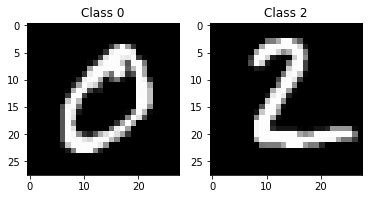

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(X_train[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[1]))
plt.subplot(1,2,2)
plt.imshow(X_test[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_test[1]))
plt.show()

x_train.view()

## Data preprocessing: the output
Now let's recode the output using a complete disjunctive coding in `Y_Train`. We have two ways of coding the outputs:
 - y_train a vector of 60 000 digits $\in$ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
 - Y_Train a binary matrix of size 60 000 by 10

In [6]:
num_classes = 10;
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

Y_train.view()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Let's start with fully connected neural networks (NN) 
They are also called multi layered perceptrons (MLP). 
In that case, 
the sequential model of keras is used mainly because its more simple (for a discusion on the two keras modes see for instance https://jovianlin.io/keras-models-sequential-vs-functional/).
MLP have fully connected layers called `Dense` in Keras (https://keras.io/layers/core/).


In [7]:
from keras.models import Sequential
from keras.layers import Dense

### First try
Let's try to reproduce LeCun et al. 1998 reslts available on the [MNIST web site](http://yann.lecun.com/exdb/mnist/). With a
 2-layer NN with 300 hidden units, the reported error rate is  4.7%.
We begin with creating the architecture of the NN. 
- in that case the neural network is fully conected: the NN is sequential,
- the first layer contained 300 neurons with `tanh` as an activation function,
- the output layer contain 10 neurones (one per class) and the activation function is the `softmax`.

In [8]:
NN = Sequential()
NN.add(Dense(units=300, activation='tanh', input_dim=784))
NN.add(Dense(units=10, activation='softmax'))
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


Now we are going to train the NN.  
The first step here is to define the cost funtion (the loss) and the learning algorithm. 
A natural choice for the loss is the `categorical_crossentropy` well suited for multiclass classification. 
As a learning algorithm, let's began with the simple stochastic gradient descent optimizer, with default parameter initialization (that is a learning rate set at $0.01$).   
The second step consist in fitting the NN to the data. 
By setting the `verbose` parameter to 0 (no outputs during training), the computing time is significantly reduced.
This training phase may take about one minute.

In [9]:
NN.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(), 
           metrics   = ['accuracy'])
t0=time.time()
NN.fit(x_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))


total computing time: 28.193730115890503


The quality of this NN is determined by measuring its error rate on the test set.

In [10]:
score = NN.evaluate(x_test, Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

10000/10000 [==============================] - 0s 27us/step
Test loss: 0.216 
Test err:  6.12 %


### Second try
Ok, let's improve our training a little bit by introducing some punch in our optimizer.
To do so we add a momentum term (`momentum=0.9`) and some L2 penalty (`decay=1e-6`).

This is done by  replacing the instruction  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`
optimizer=keras.optimizers.SGD(), `  
by  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`
optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), `

For more details on optimizers, see for instance Sebastian Ruder's blog [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/).

[//]: # (https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/http://cs231n.github.io/neural-networks-3/)

and resume training in the same way as we just did (it may take about one minute).

In [11]:
NN1 = Sequential()
NN1.add(Dense(units=300, activation='tanh', input_dim=784))
NN1.add(Dense(units=10, activation='softmax'))
NN1.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), 
            metrics=['accuracy'])

In [12]:
t0=time.time()
NN1.fit(x_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN1.evaluate(x_test, Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 29.194577932357788
10000/10000 [==============================] - 0s 26us/step
Test loss: 0.070 
Test err:  2.20 %


### Third try

There is still room for some improvement. Let's try the same architecture with another optimizer.
Try the `Adadelta` optimizer with default parameters(it may take about one minute).  
To do so, replace the instruction  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`
              optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),`  
by  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`
              optimizer=keras.optimizers.Adadelta(), `

In [13]:
NN2 = Sequential()
NN2.add(Dense(units=300, activation='tanh', input_dim=784))
NN2.add(Dense(units=10, activation='softmax'))
NN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy'])
t0=time.time()
NN2.fit(x_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN2.evaluate(x_test, Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 53.85512971878052
10000/10000 [==============================] - 0s 27us/step
Test loss: 0.060 
Test err:  1.92 %


### Fourth try

In the MNIST leaderboad, with a 
3-layer NN, 500+300 HU, softmax, cross entropy, weight decay, Hinton, reproted in 2005 an error rate of 1.53%. 	 
For fun we can use a ReLU activation function. The training phase takes about 5 minutes.

In [14]:
NN3 = Sequential()
NN3.add(Dense(units=500, activation='relu', input_dim=784))
NN3.add(Dense(units=300, activation='tanh'))
NN3.add(Dense(units=10, activation='softmax'))

NN3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy'])

NN3.summary()
              
t0=time.time()
NN3.fit(x_train, Y_train, epochs=20, verbose = 0)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN3.evaluate(x_test, Y_test, verbose=0)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_8 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                3010      
Total params: 545,810
Trainable params: 545,810
Non-trainable params: 0
_________________________________________________________________

total computing time: 203.28213500976562
Test loss: 0.073 
Test err:  1.46 %


## Let's continue with Convolutional neural networks (CNN) 

In the MNIST leaderboad, LeCun et al. 1998 reported with LeNet-5 an error rate of 0.95%.
LeNet-5 is a convolutional neural network.
<img src="https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-11.34.51-AM.png" alt="MNIST data" width="360" height="270" border="5" />
Convolution used to process images are 2d convolutions taking tensors as input and output.
To fit into the first 2d convolutional layer, the input have to be recast as tensor of dimension $28 \times 28 \times 1$. This can be perform by using a reshape.


In [15]:
img_rows, img_cols = 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(60000, 28, 28, 1)

## First try
With a simplified version of LeNet-5 and with ReLU instead of hyperbolic tangent as activation function. It takes about 3 minutes.

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

CNN = Sequential()

CNN.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(16, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
CNN.add(Dense(120, activation='relu'))
CNN.add(Dense(84, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 140.80635786056519
10000/10000 [==============================] - 1s 113us/step
Test loss: 0.036 
Test err:  0.93 %


## Second try 
With a CNN slightly more complex.

In [17]:
CNN = Sequential()
CNN.add(Conv2D(32, kernel_size=(5, 5),
           activation='relu',
          input_shape=(28,28,1)))
CNN.add(Conv2D(64, (3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))
CNN.add(Flatten())
CNN.add(Dense(128, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(10, activation='softmax'))
CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               991360    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

we proceed to the training in the same way, using `Adadelta` as optimizer. It may take about 15 minutes.

In [18]:
t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 761.9349110126495
10000/10000 [==============================] - 4s 417us/step
Test loss: 0.024 
Test err:  0.63 %


# Let's sumarize
| Architecture  |Size&nbsp;&nbsp;| Optimizer  |CPU Time |GPU Time | Error   |
|:------------- |---------------:|:----------:|:-------:|:-------:|:-------:|
| NN 300 HU     |   238,510      | SGD        | 28&nbsp;| 20&nbsp;| 6.12%   |
| NN 300 HU     |   238,510      | SGD+mom+wd | 29&nbsp;| 22&nbsp;| 2.20%   |
| NN 300 HU     |   238,510      | Adadelta   | 54&nbsp;| 54&nbsp;| 1.92%   |
| NN 500-300 HU |   545,810      | Adadelta   |203&nbsp;| 64&nbsp;| 1.46%   |
| CNN My_LeNet-5|    44,426      | Adadelta   |141&nbsp;| 56&nbsp;| 0.93%   |
| CNN Larger    |  1,011,978     | Adadelta   |762&nbsp;| 71&nbsp;| 0.63%   |

The GPU used is a NVIDIA GeForce GTX 1080 Ti (thanks to [Cyprien Ruffino](https://github.com/cyprienruffino)) and the CPU is the one of a MacBookPro.

# Your turn: 

Do your best with the [Fashion-MNIST data set](https://github.com/zalandoresearch/fashion-mnist) with a budget of 1 minute, 5 minutes and 15 minutes, and compare with the state of the art (see for instance https://www.kaggle.com/pavansanagapati/fashion-mnist-cnn-model-with-tensorflow-keras) and do better than the Google autoML https://www.statworx.com/de/blog/a-performance-benchmark-of-google-automl-vision-using-fashion-mnist/.

<img src="https://markusthill.github.io/images/2017-10-12-zalandos-fashion-mnist-dataset/zalando10x10.jpeg" alt="MNIST data" width="360" height="270" border="5" />